In [17]:
from sklearn import datasets, model_selection
import numpy as np
from scipy.sparse import csr_matrix, hstack


class LogisticRegression():
    def __init__(self):
        pass

    @staticmethod
    def loss_function(X, y ,theta):
        y_prediction = LogisticRegression.sigmod(X.dot(theta))
        loss = -1./X.shape[0] * (y*np.log(y_prediction)+ (1-y)*np.log(1-y_prediction)).sum()
        return loss
    
    @staticmethod
    def gradient(X, y, theta):
        gradient = 1./X.shape[0] * np.dot(X.transpose(), LogisticRegression.sigmod(X.dot(theta))-y)
        return gradient
    
    @staticmethod
    def sigmod(z):
        return 1./(1+ np.exp(-z))
    
    @staticmethod
    def train(X_train, y_train, theta, episode,
            learning_rate=0.01, 
            optimizer=None, 
            optimizer_params=None):
        if optimizer == None:
            #trian without optimizer
            grad = LogisticRegression.gradient(X_train, y_train, theta)
            theta -= learning_rate*grad
        elif optimizer == "NAG":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            momemtum = optimizer_params.setdefault('momemtum', 0.9)
            
            #trian with NAG optimizer
            grad = LogisticRegression.gradient(X_train, y_train, theta+ momemtum*Velocity)
            Velocity = momemtum*Velocity - learning_rate*grad
            theta += Velocity
            
            #store the parameter of optimizer
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "RMSprop":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)
            
            #trian with RMSprop optimizer
            grad = LogisticRegression.gradient(X_train, y_train, theta)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)            
            theta -= learning_rate*grad/(np.sqrt(epsilon) + Velocity)
            
            #store the parameter of optimizer
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adadelta":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            update_accumulate = optimizer_params.setdefault('update_accumulate', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)

            # train with Adadelta optimizer
            grad = LogisticRegression.gradient(X_train, y_train, theta)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)
            step_update = -(np.sqrt(update_accumulate+epsilon))*grad/(np.sqrt(Velocity+epsilon))
            theta +=  step_update
            update_accumulate = decay_rate*update_accumulate + (1-decay_rate)*(step_update**2)
            
            #store the parameter of optimizer
            optimizer_params['update_accumulate'] = update_accumulate
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adam":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            S = optimizer_params.setdefault('S', np.zeros(theta.shape))
            beta1 =  optimizer_params.setdefault('beta1', 0.9)
            beta2 = optimizer_params.setdefault('beta2', 0.999)
            epsilon = optimizer_params.setdefault('epsilon', 1e-8)
            
            grad = LogisticRegression.gradient(X_train, y_train, theta)
            S = beta1*S + (1-beta1)*grad
            Velocity = beta2*Velocity + (1-beta2)*(grad**2)
            
            S_t = S/(1 - (beta1**episode))
            Velocity_t = Velocity/(1- (beta2**episode))
            step_update = - learning_rate * S_t/ (np.sqrt(Velocity_t) + epsilon)
            theta += step_update
            
            #store the parameter of optimizer
            optimizer_params['S'] = S
            optimizer_params['Velocity'] = Velocity
        return theta

    @staticmethod
    def accuracy_of_classification(X, y, theta, threshold=0.5):
        y_prediction = LogisticRegression.sigmod(X.dot(theta))
        y_prediction[y_prediction<threshold] = 0
        y_prediction[y_prediction>=threshold] = 1
        
        #compute accuray of classification
        classification = y-y_prediction
        index = np.where(classification==0)
        accuracy = len(index[0])/classification.shape[0]
        return accuracy

In [13]:
def data_loader(file, n_features=None):
    if n_features==None:
        inputs,labels = datasets.load_svmlight_file(file)
    else:
        inputs,labels = datasets.load_svmlight_file(file,n_features=n_features)
    one = np.ones((inputs.shape[0],1))
    inputs = hstack( [inputs, csr_matrix(one)] ).toarray()
    labels = np.array(labels).reshape(inputs.shape[0],1)
    labels[labels==-1] = 0
    return inputs, labels

def get_batch(X, y ,mini_batch):
    """use to select the samples randomly"""
    index = np.random.randint(0,X.shape[0], size=mini_batch, dtype=int)
    return X[index,:], y[index]

def plot_loss(test_loss, test_accuracy):
    import matplotlib.pyplot as plt
    figure1 = plt.figure(1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(test_loss, label="test_loss")
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(test_accuracy)
    plt.show()

def main(trian_file, test_file, 
        learning_rate=0.01, 
        threshold=0.5, 
        mini_batch=64, 
        epoch=1000,     
        optimizer=None,
        optimizer_params=None):
    X_train, y_train = data_loader(trian_file)
    X_test, y_test = data_loader(test_file, X_train.shape[1]-1)
    theta = np.random.random((X_train.shape[1], 1))
    train_loss = []
    test_loss = []
    test_accuracy = []
    for episode in range(1,epoch):
        X_train_batch, y_train_batch = get_batch(X_train, y_train, mini_batch)
        theta = LogisticRegression.train(X_train_batch, y_train_batch, theta, episode=episode, 
                                         learning_rate=learning_rate, optimizer=optimizer, optimizer_params=optimizer_params)
        
        X_test_batch, y_test_batch = get_batch(X_test, y_test, mini_batch)
        loss = LogisticRegression.loss_function(X_test_batch, y_test_batch,theta)
        test_loss.append(loss)
        accuracy = LogisticRegression.accuracy_of_classification(X_test_batch, y_test_batch, theta, threshold)
        test_accuracy.append(accuracy)
    plot_loss(test_loss, test_accuracy)
    print('lower test loss: ', min(test_loss))
    print('best classification accuracy: ', max(test_accuracy))

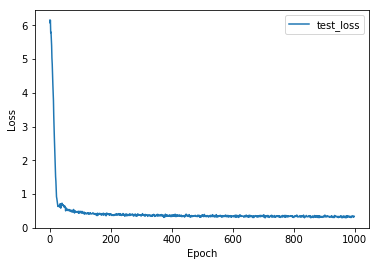

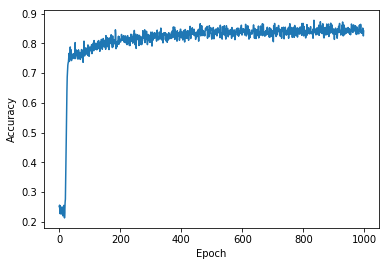

lower test loss:  0.296892291059
best classification accuracy:  0.8779296875


In [12]:
# the result of Logistic Regression with NAG
train_params = {
    'trian_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-2,
    'epoch': 1000,
    'threshold': 0.5,
    'mini_batch': 1024,
    'optimizer': "NAG"
}
optimizer_params={
    'momemtum': 0.9
}
main(**train_params, optimizer_params=optimizer_params)

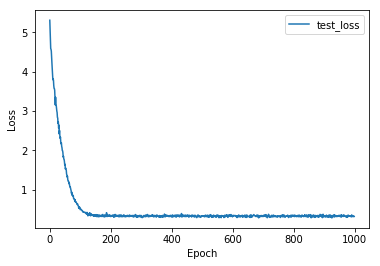

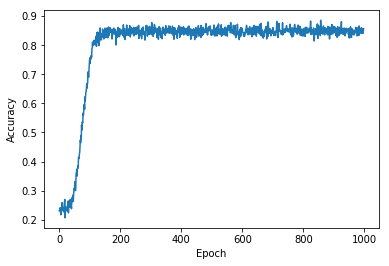

lower test loss:  0.279613835006
best classification accuracy:  0.8857421875


In [16]:
# the result of Logistic Regression with RMSprop
train_params = {
    'trian_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-3,
    'epoch': 1000,
    'threshold': 0.5,
    'mini_batch': 1024,
    'optimizer': "RMSprop"
}
optimizer_params={
    'decay_rate': 0.9,
    "epsilon":1e-7
}
main(**train_params, optimizer_params=optimizer_params)

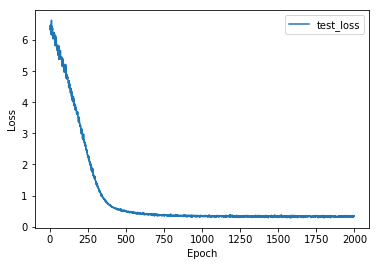

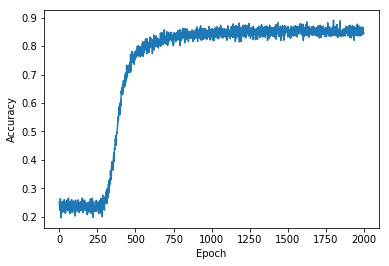

lower test loss:  0.279025162599
best classification accuracy:  0.890625


In [19]:
# the result of Logistic Regression with Adadelta
train_params = {
    'trian_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-3,
    'epoch': 2000,
    'threshold': 0.5,
    'mini_batch': 1024,
    'optimizer': "Adadelta"
}
optimizer_params={
    'decay_rate': 0.9,
    "epsilon":1e-7
}
main(**train_params, optimizer_params=optimizer_params)

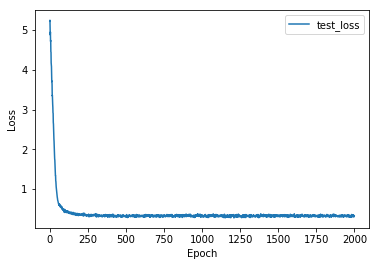

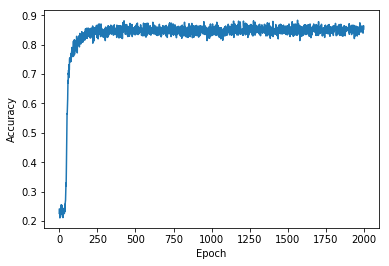

lower test loss:  0.274318107181
best classification accuracy:  0.8837890625


In [22]:
# the result of Logistic Regression with Adam
train_params = {
    'trian_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-2,
    'epoch': 2000,
    'threshold': 0.5,
    'mini_batch': 1024,
    'optimizer': "Adam"
}
optimizer_params={
    'beta1': 0.9,
    "beta2":0.99,
    "epsilon":1e-7
}
main(**train_params, optimizer_params=optimizer_params)